# Notebook for LDA

In [2]:
#import relevant packages 

import pandas as pd
import numpy as np

from datetime import datetime #To check start and end time when running code
from tqdm import tqdm #This is for creating progress bars.
import logging #This is to provide logging of information when running the LDA
import sys #This is to disable logging when it's no longer needed
import pickle #To store and open previously saved machine learning models 

#import nlkt libaries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer # Porter is used below. This is an alternative, harsher stemmer. 
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer
import string
from collections import defaultdict

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.gridspec as gridspec

#import packages for regular expressions 
import regex
import re

In [191]:
#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

In [4]:
#import datasets 
data_danish = pd.read_csv('data_danish.csv', index_col=0)

In [5]:
#Duplicates in data

#we choose to drop duplicates whereas we do not risk to make topics based on the same 
#tweets and re-tweets.

#dropping duplicates
data_danish_lda = data_danish.drop_duplicates(subset = 'tweet')

In [6]:
print("Tweets before dropping duplicates:", data_danish.shape)
print("Tweets after dropping duplicates:", data_danish_lda.shape)

Tweets before dropping duplicates: (9449, 15)
Tweets after dropping duplicates: (9273, 15)


In [351]:
data_danish_lda.head(3)

,actor,tweet,date,retweet,date_convert,@mentions,#hashtags,emojis,clean_text,language,words,without_stopwords,lemmas,proc_text,bigrams,proc_text_all
0,PlanBornefonden,"13-årige Larissa bor i Sahel-regionen, og var ...",2021-05-14 09:03:00,nan,2021-05-14,None,,,årige larissa bor i sahelregionen og var i tvu...,da,"[årige, larissa, bor, i, sahelregionen, og, va...","[årige, larissa, bor, sahelregionen, tvunget, ...","[årig, larissa, bor, sahelregion, tvinge, flyg...",årig larissa bor sahelregion tvinge flygte lan...,"[årig_larissa, larissa_bor, bor_sahelregion, s...",årig larissa bor sahelregion tvinge flygte lan...
1,PlanBornefonden,Vi ønsker alle muslimer en god Eid i aften! Ei...,2021-05-12 14:00:02,nan,2021-05-12,None,,,vi ønsker alle muslimer en god eid i aften eid...,da,"[vi, ønsker, alle, muslimer, en, god, eid, i, ...","[ønsker, muslimer, god, eid, aften, eid, mubarak]","[ønske, muslim, god, eid, aften, eid, mubarak]",ønske muslim god eid aften eid mubarak,"[ønske_muslim, muslim_god, god_eid, eid_aften,...",ønske muslim god eid aften eid mubarak ønske_m...
2,PlanBornefonden,Kom til samtalekøkken med @BosseStine og @Clau...,2021-05-12 11:58:03,@dorthe10,2021-05-12,"[BosseStine, ClausMeyerDK]",dkfood,,kom til samtalekøkken med og den maj og spis e...,da,"[kom, til, samtalekøkken, med, og, den, maj, o...","[kom, samtalekøkken, maj, spis, lækker, retter...","[komme, samtalekøkken, maj, spise, lækker, ret...",komme samtalekøkken maj spise lækker ret menu ...,"[komme_samtalekøkken, samtalekøkken_maj, maj_s...",komme samtalekøkken maj spise lækker ret menu ...


In [352]:
# checking a string with multiple hashtags 
data_danish_lda['#hashtags'][9446]

' Caritas dkaid humanitarian '

In [353]:
#removing whitespaces and popular hashtags
string = []
for element in data_danish_lda['#hashtags']:
  item = re.sub(',', ' ', element) # remove ,
  item = re.sub('-19', '', item) # remove 19 from covid-19
  item = re.sub('19', '', item) # remove 19 from covid-19

  item = item.lower() #lower all text 
  item = re.sub('dkpol', '', item) #remove hashtag
  item = re.sub('_', '', item)
  item = re.sub('dkaid', '', item) #remove hashtag
  item = re.sub(r'\s+', " ", item) #remove more whitespaces
  item = item.strip() #remove leading and last whitespace
  #item = re.sub('[^a-zA-ZÆæØøÅå]+', ' ', element) # only keeping letters 
  string.append(item)


data_danish_lda['hashtags_clean'] = string

<ipython-input-353-309197346355>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_danish_lda['hashtags_clean'] = string


In [174]:
data_danish_lda['hashtags_clean'][9446]

'caritas humanitarian'

We do not make bigrams of hashtags, as we methodological do not perceive hashtags as words, where grouping words appearing next to each other can be bring meaning and differetn meanings to a word.

In [354]:
#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas() #Creates a progress bar. Use progress_apply instead of apply.

#Creating a column of unigrams from the stemmed tweet text
data_danish_lda['hashtags_token'] = data_danish_lda['hashtags_clean'].progress_apply(lambda x: tokenizer.tokenize(x))

100%|██████████| 9273/9273 [00:00<00:00, 55969.93it/s]
<ipython-input-354-16df89138396>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_danish_lda['hashtags_token'] = data_danish_lda['hashtags_clean'].progress_apply(lambda x: tokenizer.tokenize(x))


In [355]:
#Combining unigrams, hashtags and bigrams in one column
data_danish_lda['tokens'] = data_danish_lda.lemmas+data_danish_lda.bigrams+data_danish_lda.hashtags_token


<ipython-input-355-9dfa68ae85ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_danish_lda['tokens'] = data_danish_lda.lemmas+data_danish_lda.bigrams+data_danish_lda.hashtags_token


In [356]:

#after inspecting the topics we can see that the word "barn" occurs in most of them
#therefore, we try removing them 
data_danish_lda["tokens"]
words_no_f = []
for lst in data_danish_lda["tokens"]:
    words_no_f.append([word for word in lst if word != "f"])

#If you want "barn" in the LDA, outcomment this snip of code
data_danish_lda["tokens"]
words_no_f = []
for lst in data_danish_lda["tokens"]:
    words_no_f.append([word for word in lst if word != "no"])

Notably, it is harder to apply coherent models to a corpus with short documents as we do with tweets (which are very short) than longer documents. 

In the LDA model, we set alpha as auto, which mean that the alpha is both low and asymmetric (favourite topics in docs). Notably, we ackknowledge that every doc has a preference --> docs have dominated topics and we let the model distribute the topics by this 

We are interested in what the NGOs talk about, eg. the topics. Consequently, we have remove the #'s before the hashtags treating the hashtags as regular words. This is due to the methodological choice that we consider words and hashtags as the same "value" when creating topics. 

## Preparing the LDA

In [365]:
#Create a id2word dictionary

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(data_danish_lda['tokens']) 

#Viewing how many words are in our vocabulary
print(len(id2word))
#Removing very frequent and infrequent words
id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)
print(len(id2word))

#Creating a corpus object 

corpus = [id2word.doc2bow(doc) for doc in data_danish_lda['tokens']]


# build a dictionary where for each tweet, each word has its own id.
# We have xx tweets 
tweets_dictionary = Dictionary(data_danish_lda.tokens)

# Here we build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in data_danish_lda.tokens]

116377
2838


In [358]:
print(len(corpus))
print(len(tweets_corpus))

9273
9273


We have explored removing very frequent words by setting no_above to 0.90. However, the results and topics were most distinct beforehand. Since we already have removed stopwords, lemmatized etc., we choose to set no_above to **.999*

In [161]:
# Make a for loop creating lda_models with different amount of topics
# compute coherence
tweets_coherence = []

for nb_topics in range(1,30):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, 
                   passes=10, alpha='auto')
    #^alpha='auto'
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)


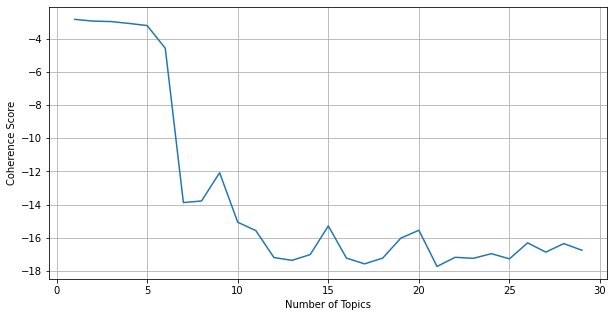

In [162]:
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,30),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid(zorder=3)
#plt.show()

plt.savefig('coherence_score_autoalpha_hashtags_09_test.png')

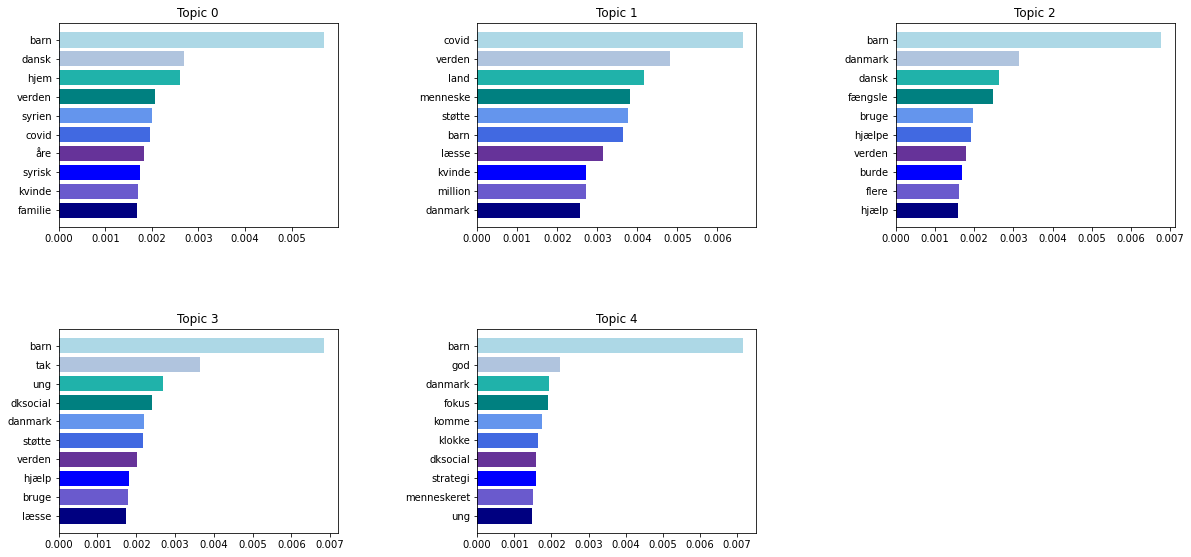

In [368]:
# 5 topics 
k = 5
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary,
                      passes=20, alpha='auto')

#BETA PARAMETERS 
def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    #Plot the data:
    
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',
                 color=('lightblue', 'lightsteelblue', 'lightseagreen', 'teal', 'cornflowerblue', 'royalblue', 
                        'rebeccapurple','blue', 'slateblue', 'navy'), ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
    plt.savefig('til test.png')   
  
plot_top_words(tweets_lda, k, 10)

In [369]:
#Viewing the shape of base_model.get_topics() to verify that the shape is (topics, tokens)
tweets_lda.get_topics().shape 

(5, 116377)

## Investigating the LDA: Gamma parameters

In [372]:
data_danish_lda = data_danish_lda.reset_index()
data_danish_lda.tail(3)

,level_0,index,actor,tweet,date,retweet,date_convert,@mentions,#hashtags,emojis,...,language,words,without_stopwords,lemmas,proc_text,bigrams,proc_text_all,hashtags_clean,hashtags_token,tokens
9270,9270,9446,CaritasDanmark,Dolores Halpin-Bachmann har arbejdet for #Cari...,2020-02-07 10:49:47,nan,2020-02-07,None,Caritas dkaid humanitarian,,...,da,"[dolores, halpinbachmann, har, arbejdet, for, ...","[dolores, halpinbachmann, arbejdet, siden, man...","[dolore, halpinbachmann, arbejde, siden, mange...",dolore halpinbachmann arbejde siden mangeårig ...,"[dolore_halpinbachmann, halpinbachmann_arbejde...",dolore halpinbachmann arbejde siden mangeårig ...,caritas humanitarian,"[caritas, humanitarian]","[dolore, halpinbachmann, arbejde, siden, mange..."
9271,9271,9447,CaritasDanmark,Børn skal være børn - https://t.co/h5xNWh7a7U ...,2020-01-31 13:48:55,nan,2020-01-31,None,DKindsamling BørnUdenHjem DKaid,,...,da,"[børn, skal, være, børn]","[børn, børn]","[barn, barn]",barn barn,[barn_barn],barn barn barn_barn DKindsamling BørnUdenHjem ...,dkindsamling børnudenhjem,"[dkindsamling, børnudenhjem]","[barn, barn, barn_barn, dkindsamling, børnuden..."
9272,9272,9448,CaritasDanmark,”Ansvaret hviler i høj grad på jeres generatio...,2020-01-21 12:00:47,nan,2020-01-21,None,verdensmålene SDGs,,...,da,"[ansvaret, hviler, i, høj, grad, på, jeres, ge...","[ansvaret, hviler, høj, grad, jeres, generatio...","[ansvar, hvile, høj, grade, I, generation, lan...",ansvar hvile høj grade I generation langt fing...,"[ansvar_hvile, hvile_høj, høj_grade, grade_I, ...",ansvar hvile høj grade I generation langt fing...,verdensmålene sdgs,"[verdensmålene, sdgs]","[ansvar, hvile, høj, grade, I, generation, lan..."


In [373]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 
document_topics = list(tweets_lda.get_document_topics(tweets_corpus)) 

In [374]:
len(document_topics)

9273

In [381]:
#Creating a list of names for all 10 topics
topics = ['topic_{}'.format(t) for t in range(0,5)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),5)), columns = topics)

for i, doc in enumerate(document_topics):
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]


In [383]:
gamma_probs.shape

(9273, 5)

In [382]:
gamma_probs.tail()

,topic_0,topic_1,topic_2,topic_3,topic_4
9268,0.00000,0.000000,0.000000,0.986477,0.000000
9269,0.00000,0.237831,0.000000,0.757490,0.000000
9270,0.00000,0.988638,0.000000,0.000000,0.000000
9271,0.01155,0.269588,0.010121,0.698640,0.010099
9272,0.00000,0.000000,0.000000,0.880649,0.113925


In [385]:
#Merging with the original dataframe 
gamma_df = pd.concat((data_danish_lda,gamma_probs), axis = 1)

#Viewing the concatenated dataframe
gamma_df.head()

,level_0,index,actor,tweet,date,retweet,date_convert,@mentions,#hashtags,emojis,...,bigrams,proc_text_all,hashtags_clean,hashtags_token,tokens,topic_0,topic_1,topic_2,topic_3,topic_4
0,0,0,PlanBornefonden,"13-årige Larissa bor i Sahel-regionen, og var ...",2021-05-14 09:03:00,nan,2021-05-14,None,,,...,"[årig_larissa, larissa_bor, bor_sahelregion, s...",årig larissa bor sahelregion tvinge flygte lan...,,[],"[årig, larissa, bor, sahelregion, tvinge, flyg...",0.000000,0.000000,0.992848,0.0,0.000000
1,1,1,PlanBornefonden,Vi ønsker alle muslimer en god Eid i aften! Ei...,2021-05-12 14:00:02,nan,2021-05-12,None,,,...,"[ønske_muslim, muslim_god, god_eid, eid_aften,...",ønske muslim god eid aften eid mubarak ønske_m...,,[],"[ønske, muslim, god, eid, aften, eid, mubarak,...",0.000000,0.000000,0.000000,0.0,0.976431
2,2,2,PlanBornefonden,Kom til samtalekøkken med @BosseStine og @Clau...,2021-05-12 11:58:03,@dorthe10,2021-05-12,"[BosseStine, ClausMeyerDK]",dkfood,,...,"[komme_samtalekøkken, samtalekøkken_maj, maj_s...",komme samtalekøkken maj spise lækker ret menu ...,dkfood,[dkfood],"[komme, samtalekøkken, maj, spise, lækker, ret...",0.000000,0.000000,0.000000,0.0,0.989029
3,3,3,PlanBornefonden,"Mali, Burkina Faso og Niger - også kendt som d...",2021-05-12 10:00:02,nan,2021-05-12,None,,,...,"[mali_burkina, burkina_faso, faso_niger, niger...",mali burkina faso niger kendt central sahele s...,,[],"[mali, burkina, faso, niger, kendt, central, s...",0.000000,0.994836,0.000000,0.0,0.000000
4,4,4,PlanBornefonden,Vores seje kollega Iben Østergaard Markussen f...,2021-05-12 09:23:14,@dorthe10,2021-05-12,"[radioloud_dk, MaternityF]",,,...,"[sej_kollega, kollega_ibe, ibe_østergaard, øst...",sej kollega ibe østergaard markusse fortæller ...,,[],"[sej, kollega, ibe, østergaard, markusse, fort...",0.993019,0.000000,0.000000,0.0,0.000000


In [390]:
gamma_df.shape


(9273, 24)

In [391]:
gamma_df.to_csv('gamma_df_lda_tweets_5topics.csv')

### Vizualizing a topic over time 

In [392]:
#Using regex to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in tweets_lda.print_topics(50,10)]
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")
    

------ Topic 0 ------
barn dansk hjem verden syrien covid åre syrisk kvinde familie

------ Topic 1 ------
covid verden land menneske støtte barn læsse kvinde million danmark

------ Topic 2 ------
barn danmark dansk fængsle bruge hjælpe verden burde flere hjælp

------ Topic 3 ------
barn tak ung dksocial danmark støtte verden hjælp bruge læsse

------ Topic 4 ------
barn god danmark fokus komme klokke dksocial strategi menneskeret ung



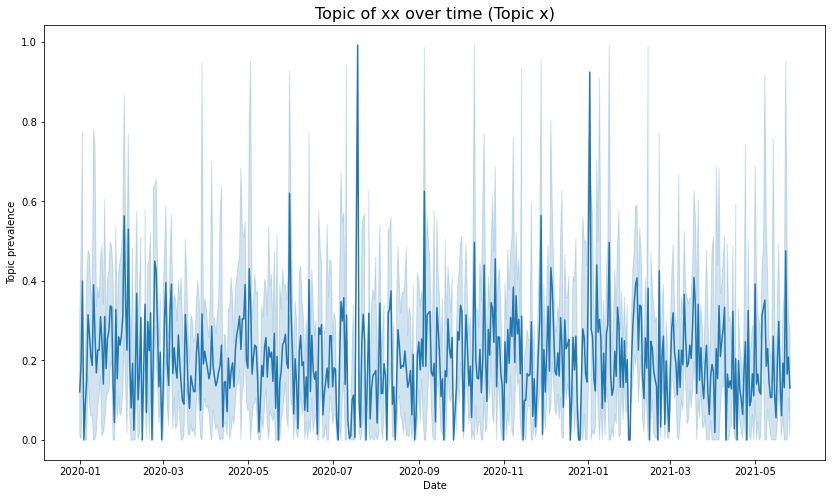

In [398]:
#Setting a theme

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date_convert', y = 'topic_3', data = gamma_df, palette = palette)

plt.title('Topic of xx over time (Topic x)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

# LDA - aggregated tweets pr actor

In [406]:
data_danish_lda.head(2)


,actor,tweet,date,retweet,date_convert,@mentions,#hashtags,emojis,clean_text,language,words,without_stopwords,lemmas,proc_text,bigrams,proc_text_all,hashtags_clean,hashtags_token,tokens
0,PlanBornefonden,"13-årige Larissa bor i Sahel-regionen, og var ...",2021-05-14 09:03:00,nan,2021-05-14,None,,,årige larissa bor i sahelregionen og var i tvu...,da,"[årige, larissa, bor, i, sahelregionen, og, va...","[årige, larissa, bor, sahelregionen, tvunget, ...","[årig, larissa, bor, sahelregion, tvinge, flyg...",årig larissa bor sahelregion tvinge flygte lan...,"[årig_larissa, larissa_bor, bor_sahelregion, s...",årig larissa bor sahelregion tvinge flygte lan...,,[],"[årig, larissa, bor, sahelregion, tvinge, flyg..."
1,PlanBornefonden,Vi ønsker alle muslimer en god Eid i aften! Ei...,2021-05-12 14:00:02,nan,2021-05-12,None,,,vi ønsker alle muslimer en god eid i aften eid...,da,"[vi, ønsker, alle, muslimer, en, god, eid, i, ...","[ønsker, muslimer, god, eid, aften, eid, mubarak]","[ønske, muslim, god, eid, aften, eid, mubarak]",ønske muslim god eid aften eid mubarak,"[ønske_muslim, muslim_god, god_eid, eid_aften,...",ønske muslim god eid aften eid mubarak ønske_m...,,[],"[ønske, muslim, god, eid, aften, eid, mubarak,..."


In [407]:
#data_danish_lda['tokens_str'] = data_danish_lda['tokens'].apply(str)
data_danish_lda['tokens_str'] = [' '.join(map(str, l)) for l in data_danish_lda['tokens']]

In [408]:
tweets_agg = data_danish_lda.groupby(['actor'], as_index = False).agg({'tweet': ' '.join,
                                                                      'tokens_str': ' '.join})
tqdm.pandas() #Creates a progress bar. Use progress_apply instead of apply.

#Creating a column of unigrams from the stemmed tweet text
tweets_agg['tokens'] = tweets_agg['tokens_str'].progress_apply(lambda x: tokenizer.tokenize(x))

100%|██████████| 27/27 [00:01<00:00, 13.86it/s]


In [409]:

#removing whitespaces and popular hashtags
string = []
for element in tweets_agg['tokens_str']:
  item = re.sub('\+', ' ', element) # remove ,
  item = re.sub(r'\s+', " ", item) #remove more whitespaces

  string.append(item)


tweets_agg['tokens_str'] = string

In [410]:
#Creating a column of unigrams from the stemmed tweet text
tweets_agg['tokens'] = tweets_agg['tokens_str'].progress_apply(lambda x: tokenizer.tokenize(x))

100%|██████████| 27/27 [00:01<00:00, 13.80it/s]


In [411]:
#after inspecting the topics we can see that the word "barn" occurs in most of them
#therefore, we try removing them 

words_no_s = []
for lst in tweets_agg['tokens']:
    words_no_s.append([word for word in lst if word != "s"])

tweets_agg['tokens'] = words_no_s


words_no_ = []
for lst in tweets_agg['tokens']:
    words_no_.append([word for word in lst if word != "+"])
tweets_agg['tokens'] = words_no_

words_no_1 = []
for lst in tweets_agg['tokens']:
    words_no_1.append([word for word in lst if word != " "])
tweets_agg['tokens'] = words_no_1

words_no_1 = []
for lst in tweets_agg['tokens']:
    words_no_1.append([word for word in lst if word != "|"])
tweets_agg['tokens'] = words_no_1

words_no_1 = []
for lst in tweets_agg['tokens']:
    words_no_1.append([word for word in lst if word != "-"])
tweets_agg['tokens'] = words_no_1

In [412]:
tweets_agg.head(2)

,actor,tweet,tokens_str,tokens
0,ADRA_Danmark,Humanitær støtte til #Syrien sker i tæt samarb...,humanitær støtte ske samarbejde gode partner t...,"[humanitær, støtte, ske, samarbejde, gode, par..."
1,AVestegnen,"Tænk at dine børn hopper på trampolin, mens de...",tænke din barn hoppe trampolin men ske bombeek...,"[tænke, din, barn, hoppe, trampolin, men, ske,..."


In [413]:
#Create a id2word dictionary

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) 

#Viewing how many words are in our vocabulary
print('Length of id2word:', len(id2word))
#Removing very frequent and infrequent words
id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)
print('Length of id2word after filtering:', len(id2word))

#Creating a corpus object 

corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']]


# build a dictionary where for each tweet, each word has its own id.
# We have xx tweets 
tweets_dictionary = Dictionary(tweets_agg.tokens)

# Here we build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in tweets_agg.tokens]

print('Length of corpus:',len(corpus))
print(len(tweets_corpus))

Length of id2word: 116060
Length of id2word after filtering: 1273
Length of corpus: 27
27


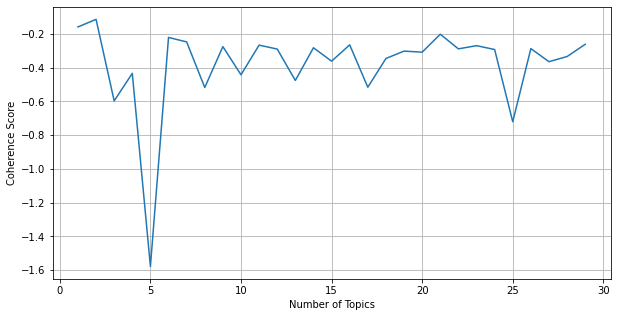

In [340]:
# Make a for loop creating lda_models with different amount of topics
# compute coherence
tweets_coherence = []

for nb_topics in range(1,30):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, 
                   passes=10, alpha='auto')
    #^alpha='auto'
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,30),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid(zorder=3)
#plt.show()

plt.savefig('coherence_score_autoalpha_aggregated.png')

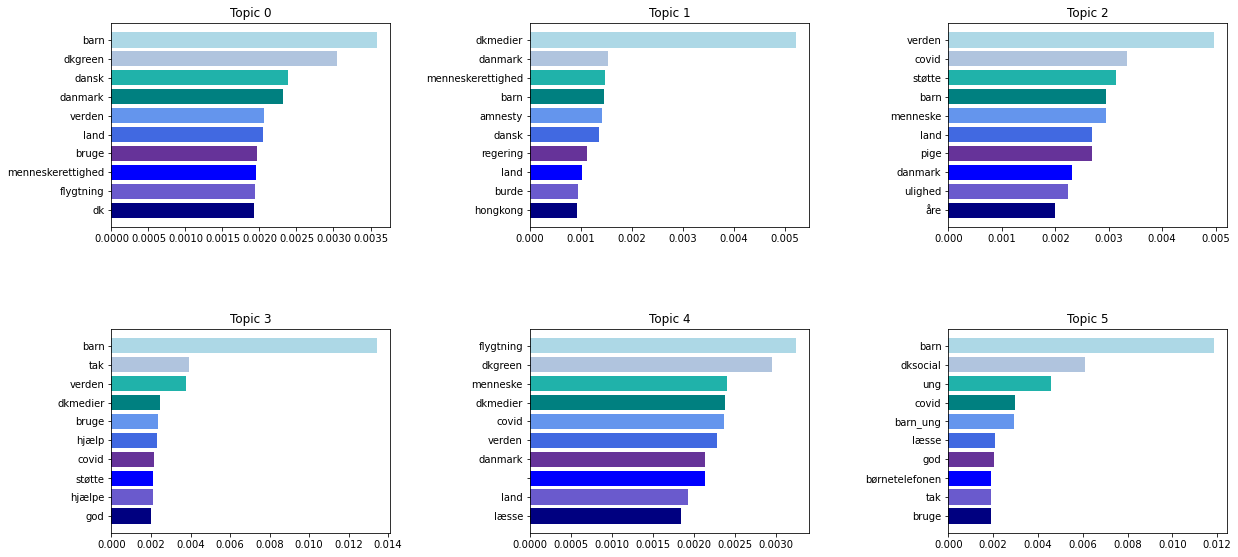

In [415]:
#10 topics with hashtags 
k = 6
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary,
                      passes=20, alpha='auto')

#BETA PARAMETERS 
def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    #Plot the data:
    
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',
                 color=('lightblue', 'lightsteelblue', 'lightseagreen', 'teal', 'cornflowerblue', 'royalblue', 
                        'rebeccapurple','blue', 'slateblue', 'navy'), ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
    plt.savefig('6_topics_auto_agg.png')   
  
plot_top_words(tweets_lda, k, 10)

## Gamma parameters for model on actor level

In [416]:
tweets_agg = tweets_agg.reset_index()
tweets_agg.tail(3)

,index,actor,tweet,tokens_str,tokens
24,24,noedhjaelp,Tak for den store omsorg og opbakning ifm den ...,tak stor omsorg opbakning ifm personlig traged...,"[tak, stor, omsorg, opbakning, ifm, personlig,..."
25,25,oxfamibis,Vi er dybt bekymrede over situationen i Jerusa...,dybt bekymre situation jerusalem far yderliger...,"[dybt, bekymre, situation, jerusalem, far, yde..."
26,26,redbarnetdk,Børnene er altid de mest udsatte – også i konf...,barn altid udsat konflikt barn angst barrikade...,"[barn, altid, udsat, konflikt, barn, angst, ba..."


In [417]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 
document_topics = list(tweets_lda.get_document_topics(tweets_corpus)) 
len(document_topics)
#Creating a list of names for all 10 topics
topics = ['topic_{}'.format(t) for t in range(0,6)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),6)), columns = topics)

for i, doc in enumerate(document_topics):
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]

gamma_probs.tail()
#gamma_df = gamma_df.drop(columns=['level_0', 'index'])
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

#Viewing the concatenated dataframe
gamma_df.head()
gamma_df.shape

gamma_df.to_csv('gamma_df_lda_actor_aggtweets_6topics.csv')